Defino las variables de entorno

In [ ]:
USER_FLAG = "--user"

REGION_BQ="us-east4"
REGION="us-central1"

# Get projet name
shell_output=!gcloud config get-value project 2> /dev/null
PROJECT_ID=shell_output[0]
print("Project ID:", PROJECT_ID)

#if (
#    SERVICE_ACCOUNT == ""
#    or SERVICE_ACCOUNT is None
3    or SERVICE_ACCOUNT == "[your-service-account]"
#):
# Get your GCP project id from gcloud
shell_output = !gcloud auth list 2>/dev/null
SERVICE_ACCOUNT = shell_output[2].strip()
print("Service Account:", SERVICE_ACCOUNT)

# Set bucket name
#BUCKET_NAME="gs://"+PROJECT_ID+"-encuestas_nps"
BUCKET_NAME="gs://speech_analytics_bucket"
#print(BUCKET_NAME)
# Create pipeline 
PIPELINE_ROOT = f"{BUCKET_NAME}/pipelines/"
print(PIPELINE_ROOT)


# API service endpoint
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
print(API_ENDPOINT)


#### El primer paso es instalar / cargar las librerias de Kubeflow y de vertex pipelines (Este pipeline funciona con la version 1.8.22 o menor)

In [2]:
#!pip install google-cloud-aiplatform==1.26.1
#!pip install google-cloud-pipeline-components==1.0.44
#!pip install kfp==1.8.22



import kfp
from typing import NamedTuple

from kfp.v2 import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import pipeline, component, Artifact, Dataset, Input, Metrics, Model, Output, ClassificationMetrics, OutputPath

from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs
import google.cloud.aiplatform as aip
from google_cloud_pipeline_components import aiplatform as gcc_aip
from datetime import datetime, timedelta
import json 

Esquema de los componentes que se van a crear, por un lado:
- Pipeline que carga modelo de pytorch (bucket) y datos de bigquery y guarda los datos en bigquery
- Pipeline que carga el modelo de sklearn (bucket) y datos de un csv / parquet

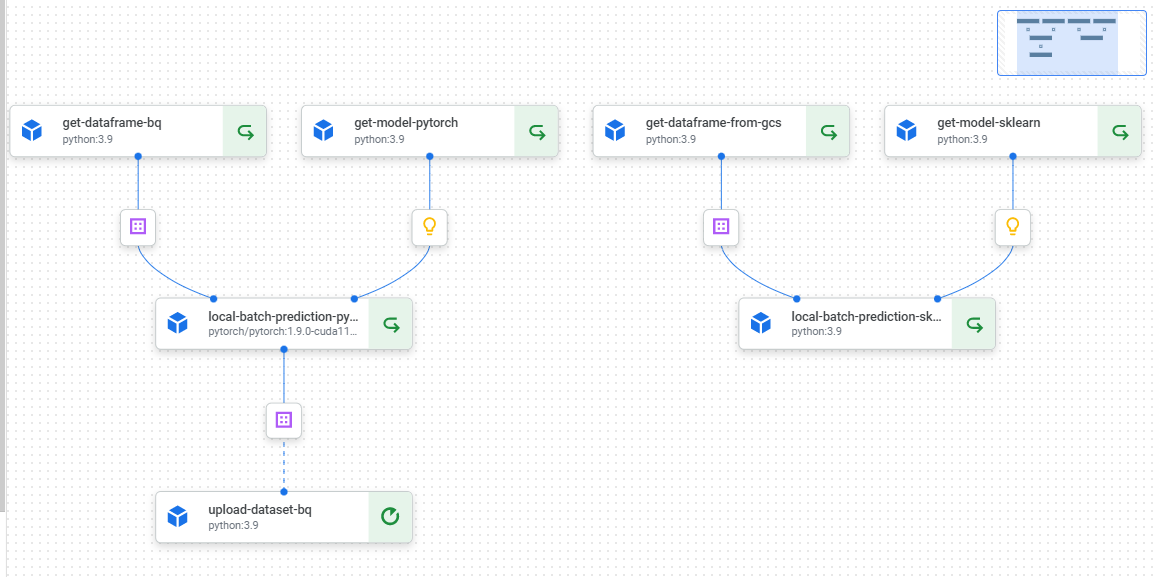

In [3]:
from IPython.display import Image
Image("img/pipeline-model-inference.png")

## 1er Componente - Levanta los datos BQ

In [196]:
# en el decorador se setea los parametros para crear el contenedor
@component(
    packages_to_install=["google-cloud-bigquery==3.10.0", "pandas==1.5.2", "pyarrow==7.0.0","db_dtypes==1.1.1","scikit-learn==1.2.0","fastparquet==2023.1.0"],
    base_image="python:3.9",
    #output_component_file="./artifacts/get_dataframe.yaml" #aqui podria definir un lugar para guardar el componente (para reutilizarlo a futuro)
)

def get_dataframe_bq(
        query_string: str,
        project_id: str,
        dataset: Output[Dataset],
        min_df_len: int= 1,
        
):
    """
    Descarga el dataset desde BigQuery y lo guarda en formato csv o parquet según se defina el parámetro dataset_format.
    Inputs: 
    - query_string: string con la query que obtiene el dataset
    - project_id: id del proyecto de GCP
    - min_df_len: int si el dataframe es mas corto que este parametro, el pipeline se detiene y se da un aviso. 
    - test_size: percentage of test dataset
    
    Outputs:
    - dataset_train: el dataset almacenado para poder enviarlo a otro componente
    - dataset_test: el dataset almacenado para poder enviarlo a otro componente
    """
    

    from google.cloud import bigquery
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    import logging

    bqclient = bigquery.Client(project=project_id)
    
    job_config = bigquery.QueryJobConfig()
    
    df = (bqclient.query(query_string, job_config=job_config).result().to_dataframe(create_bqstorage_client=False))
    
    
    # guardado de archivos, preprocessed_train & preprocessed_test son objetos "Output"
    
    #df.to_csv(dataset.path + ".csv", index=False, encoding='utf-8-sig')
    df.to_parquet(dataset.path + ".parquet.gzip" )
    logging.info("Guardado como parquet")

    if len(df) <= min_df_len:
        raise Exception(f"El DataFrame resultante es demasiado corto (tamaño = {len(df)}). Se requiere un tamaño mínimo de {min_df_len}.")
    logging.info(df.dtypes)    
    logging.info(query_string)

    

## 2do Componente - Levanta el modelo de Bucket

In [197]:
# en el decorador se setea los parametros para crear el contendor
@component(
    packages_to_install=["google-cloud", "pandas==1.5.2", "pyarrow","db_dtypes", "scikit-learn==1.2.0"],
    base_image="python:3.9",
)



def get_model_pytorch(
    model_conf_dict: dict,
    project_id: str, 
    model: Output[Model],
    get_features_name_file: bool = False,
    extension:str = ".ckpt",
)-> NamedTuple("Outputs", [("features_names", list)]):
    """
        Descarga un direcotrio  desde el storage.
        Inputs:
        - model_config_dict: diccionario con los campos bucket_name ( nombre del bucket sin gs:// ) y source_blob_name ( path dentro del bucket hacia el modelo)
        - project_id: id del proyecto 
        - extension del archivo, default ".pkl"
        - get_features_name_file: Booleano, si es true ademas del modelo se obtiene un json desde el bucket, lo buscara en la mismo bucket y direccion del modelo por el nombre feature_names.json
    
        Outputs:
        - directory : Directorio 
    """
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split as tts
    import logging
    import pickle
    from google.cloud import storage
    import json
    
    feature_names_list=[]
    
    def download_blob(bucket_name, source_blob_name, destination_file_name, project_id):
        """Downloads a blob from the bucket."""
        # The ID of your GCS bucket
        # bucket_name = "your-bucket-name"

        # The ID of your GCS object
        # source_blob_name = "storage-object-name"

        # The path to which the file should be downloaded
        # destination_file_name = "local/path/to/file"

        storage_client = storage.Client(project  = project_id)

        bucket = storage_client.bucket(bucket_name)

        # Construct a client side representation of a blob.
        # Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
        # any content from Google Cloud Storage. As we don't need additional data,
        # using `Bucket.blob` is preferred here.
        logging.info(f"Bucando el modelo en: ")
        logging.info(f"{bucket_name}/{source_blob_name}{extension}")
        blob = bucket.blob(source_blob_name + extension)
        blob.download_to_filename(destination_file_name)

        logging.info(
            "Downloaded storage object {} from bucket {} to local file {}.".format(
                source_blob_name, bucket_name, destination_file_name
            )
        )


    download_blob(model_conf_dict.get("bucket_name"), model_conf_dict.get("source_blob_name"), model.path + extension, project_id )
    

    if get_features_name_file:
        # si get_features_name_file es true se descarga el json desde el bucket, se abre y se carga en la lista 
        logging.info("Obteniendo el nombre de las features en ")
        storage_client = storage.Client(project  = project_id)
        bucket = storage_client.bucket(model_conf_dict.get("bucket_name"))
        try:
            feature_name_json_blob = '/'.join(model_conf_dict.get("source_blob_name").split('/')[:-1]) + '/feature_names.json'
            blob = bucket.blob(feature_name_json_blob)
            blob.download_to_filename("feature_names.json")
            with open("feature_names.json", 'r') as json_file:
                feature_names_list = json.load(json_file)
        except Exception as e:
            logging.error(e)
            logging.error("Error al obtener el nombre de las features, revisar si en el bucket del modelo existe un archivo con el nombre feature_names.json")
        
        
    if len(feature_names_list) == 0:
        logging.warning("features_names se devuelve vacio ya que no se especifico el get_features_name_file")

    
    return (feature_names_list,)

## 3er Componente - Batch Prediction Pytorch

In [198]:
# en el decorador se setea los parametros para crear el contendor
@component(
    packages_to_install=["pytorch-lightning==1.8.6", "google-cloud", "pandas==1.3.5", "pyarrow==7.0.0", "db_dtypes","tensorboard","transformers","scikit-learn","fastparquet"],
    base_image="pytorch/pytorch:1.9.0-cuda11.1-cudnn8-runtime",
    #output_component_file="./artifacts/get_pytorch_model.yaml"
)

def local_batch_prediction_pytorch(
    data: Input[Dataset],
    model: Input[Model],
    predictions_output: Output[Dataset],
    model_version: str,
):
    """
        Carga el modelo de pytorch, define la arquitectura del set y dataloaders y al final ejecuta el modelo sobre los datos ingresados.
        Inputs:
        - data: dataset sobre el cual se va a correr la prediccion en formato parquet.
        - model: .ckpg file que continee los pesos del modelo.
    
        Outputs:
        - predictions: predicciones del modelo en formato parquet.
    """
    import pandas as pd
    import numpy as np
    import torch
    import logging
    from google.cloud import storage
    import json
    from importlib.util import spec_from_file_location, module_from_spec
    import pandas as pd
    import numpy as np
    from tqdm.auto import tqdm
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    from torch.utils.tensorboard import SummaryWriter
    from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR


    from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
    import pytorch_lightning as pl

    from torchmetrics.functional import accuracy, auroc
    from torchmetrics import F1Score as f1
    from torchmetrics import Recall, Precision
    from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
    from pytorch_lightning.loggers import TensorBoardLogger
    import os 
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, multilabel_confusion_matrix, precision_recall_fscore_support
    if torch.cuda.is_available():
        logging.info(f"PyTorch is using the GPU: {torch.cuda.get_device_name(0)}")
    else:
        logging.info("PyTorch is not using the GPU.")
    
    df = pd.read_parquet(data.path + ".parquet.gzip", engine='fastparquet')
    #df = pd.read_csv(data.path + ".csv")
    
    MAX_TOKEN_LEN = 256
    ACCUMULATE_GRAD_BATCH = 1

    BERT_MODEL_NAME = 'bert-base-multilingual-uncased'

    LABEL_COLUMNS = ['gestion_citas_tag_manual',
    'ventas_tag_manual',
    'facturacion_consumos_tag_manual',
    'inconvenientes_servicio_tag_manual',
    'promos_descuentos_tag_manual',
    'gestion_comercial_tag_manual',
    'gestiones_administrativas_tag_manual',
    'pagos_morosidad_tag_manual',
    'ninguno_tag_manual']

    LABEL_COLUMNS_FT= ['gestion_citas_tag_manual',
    'ventas_tag_manual',
    'facturacion_consumos_tag_manual',
    'inconvenientes_servicio_tag_manual',
    'promos_descuentos_tag_manual',
    'gestion_comercial_tag_manual',
    'gestiones_administrativas_tag_manual',
    'pagos_morosidad_tag_manual',
                       'gestiones_financieras_tag_manual',
    'ninguno_tag_manual']
    
    N_CLASSES = len( LABEL_COLUMNS)
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

    
    # Custom Dataset for Inference
    class InferenceDataset(torch.utils.data.Dataset):
        def __init__(self, df, tokenizer, max_token_len):
            self.df = df
            self.tokenizer = tokenizer
            self.max_token_len = max_token_len

        def __len__(self):
            return len(self.df)

        def __getitem__(self, index):
            text = self.df.iloc[index]["text"]
            encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_token_len,
                return_token_type_ids=False,
                padding="max_length",
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten()
            }


    # Custom DataModule for Inference
    class InferenceDataModule(pl.LightningDataModule):
        def __init__(self, df, tokenizer, batch_size=8, max_token_len=128):
            super().__init__()
            self.batch_size = batch_size
            self.df = df
            self.tokenizer = tokenizer
            self.max_token_len = max_token_len

        def setup(self, stage=None):
            self.dataset = InferenceDataset(
                self.df,
                self.tokenizer,
                self.max_token_len
            )

        def train_dataloader(self):
            return DataLoader(
                self.dataset,
                batch_size=self.batch_size,
                num_workers=16
            )
        
    
    class chatClassificationTaggerFT(pl.LightningModule):

      def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        # Freeze all the weights of the BERT model
        # Freeze all the parameters of the BERT model
        for param in self.bert.parameters():
            param.requires_grad = False
        # Unfreeze the last three layers
        for layer in self.bert.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True


        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
        self.accumulate_grad_batches = ACCUMULATE_GRAD_BATCH
        self.writer = SummaryWriter()
      def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
      def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.writer.add_scalar('Loss/train', loss, global_step=self.global_step)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        #torch.cuda.empty_cache()
        return {"loss": loss, "predictions": outputs, "labels": labels}

      def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.writer.add_scalar('Loss/val', loss, global_step=self.global_step)
        self.log("val_loss", loss, prog_bar=True, logger=True)

        # Convert predictions and labels to numpy arrays
        predictions = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        # Compute precision, recall, and F1-score for each class
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions.round(), average=None, zero_division=1)

        # Log the metrics to Tensorboard
        for i, name in enumerate(LABEL_COLUMNS_FT):
            self.writer.add_scalar(f"{name}_precision/val", precision[i], global_step=self.global_step)
            self.writer.add_scalar(f"{name}_recall/val", recall[i], global_step=self.global_step)
            self.writer.add_scalar(f"{name}_f1/val", f1[i], global_step=self.global_step)

        return loss

      def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.writer.add_scalar('Loss/test', loss, global_step=self.global_step)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
      def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
          for out_labels in output["labels"].detach().cpu():
            labels.append(out_labels)
          for out_predictions in output["predictions"].detach().cpu():
            predictions.append(out_predictions)
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        for i, name in enumerate(LABEL_COLUMNS_FT):
          class_roc_auc = auroc(predictions[:, i], labels[:, i],task= "binary")
          self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
      def on_fit_end(self):
        self.writer.close()

      def on_train_end(self):
        early_stop_callback = None
        for callback in self.trainer.callbacks:
            if isinstance(callback, EarlyStopping):
                early_stop_callback = callback
                break

        if early_stop_callback is not None and early_stop_callback.stopped_epoch > 0:

            stopped_epoch = early_stop_callback.stopped_epoch
            with open("training_log.txt", "a") as f:
                f.write(f"Training finished due to early stopping at epoch {stopped_epoch}, best {self.trainer.logger.name}")
        else:
            with open("training_log.txt", "a") as f:
                f.write("Training finished in the last step.\n")

        command = f"gcloud compute instances stop {instance_name} --zone={region}"
        os.system(command)

      def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=0.00001)

        # Usando CosineAnnealingLR
        scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

        # Usando StepLR
        #scheduler = StepLR(optimizer, step_size=5, gamma=0.85)

        return dict(
          optimizer=optimizer,
          lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
          )
        )

    trained_model = chatClassificationTaggerFT.load_from_checkpoint(
    checkpoint_path = model.path+".ckpt",
    n_classes=10,
    n_warmup_steps=None,
    n_training_steps=None 
    )
    #trained_model.classifier= nn.Linear(trained_model.bert.config.hidden_size, 9)

    # Initialize your data module
    data_module = InferenceDataModule(df, tokenizer, batch_size=8, max_token_len=128)
    data_module.setup()

    # Get the dataloader
    data_loader = data_module.train_dataloader()

    # Disable tokenizer parallelism
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    # Function for inference
    def predict(model, data_loader):
        model = model.eval()
        result_dict = dict()
        predictions = []
        predictions_prob = []

        with torch.no_grad():
            for i, batch in enumerate(data_loader):
                print(f"Processing batch {i+1} of {len(data_loader)}")
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                _, output = model(input_ids, attention_mask)
                output = output.detach().cpu().numpy()  # move tensor to cpu before converting to numpy
                predictions.extend(output)
                # round the output to 4 decimals after converting to numpy and before converting to list
                sigmoid_output = torch.sigmoid(torch.tensor(output)).numpy()
                sigmoid_output = np.round(sigmoid_output, 4)
                predictions_prob.extend(sigmoid_output.tolist())

        result_dict = {'predictions': predictions, 'predictions_prob': predictions_prob}
        return result_dict

    # Assuming the model and tokenizer are already loaded
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trained_model.to(device)

    # Initialize your data module
    data_module = InferenceDataModule(df, tokenizer, batch_size=8, max_token_len=128)
    data_module.setup()

    # Get the dataloader
    data_loader = data_module.train_dataloader()

    # Run inference
    result_dict = predict(trained_model, data_loader)

    # Create DataFrame from results
    result_df = pd.DataFrame(result_dict)
    
    ############ATENTO - ACA HAY UN PROBLEMA CON EL ORDEN DE LAS COLUMNAS - HUBO QUE CAMBIAR NINGUNO Y GESTIONES_FINANCIERAS
    LABEL_COLUMNS_PRED= ['gestion_citas_prob',
    'ventas_prob',
    'facturacion_consumos_prob',
    'inconvenientes_servicio_prob',
    'promos_descuentos_prob',
    'gestion_comercial_prob',
    'gestiones_administrativas_prob',
    'pagos_morosidad_prob',
    #'gestiones_financieras_prob',
    #'ninguno_prob'
    'ninguno_prob',
    'gestiones_financieras_prob']


    predictions=pd.DataFrame(result_df["predictions"].to_list(), columns=LABEL_COLUMNS_PRED)
    logging.info(f'CONVERTING PROBS TO FLAG')

    
    # Define the convert_prob_to_binary function
    def convert_prob_to_binary(probability, threshold=0.5):
        binary_value = 1 if probability >= threshold else 0
        return binary_value


    # Apply the function to the 'Probabilities' column
    predictions['gestion_citas'] = predictions['gestion_citas_prob'].apply(convert_prob_to_binary, threshold=0.65)
    predictions['ventas'] = predictions['ventas_prob'].apply(convert_prob_to_binary, threshold=0.55)
    predictions['facturacion_consumos'] = predictions['facturacion_consumos_prob'].apply(convert_prob_to_binary, threshold=0.5)
    predictions['inconvenientes_servicio'] = predictions['inconvenientes_servicio_prob'].apply(convert_prob_to_binary, threshold=0.65)
    predictions['promos_descuentos'] = predictions['promos_descuentos_prob'].apply(convert_prob_to_binary, threshold=0.65)
    predictions['gestion_comercial'] = predictions['gestion_comercial_prob'].apply(convert_prob_to_binary, threshold=0.5)
    predictions['gestiones_administrativas'] = predictions['gestiones_administrativas_prob'].apply(convert_prob_to_binary, threshold=0.65)
    predictions['pagos_morosidad'] = predictions['pagos_morosidad_prob'].apply(convert_prob_to_binary, threshold=0.65)
    #predictions['gestiones_financieras'] = predictions['gestiones_financieras_prob'].apply(convert_prob_to_binary, threshold=0.65)
    #predictions['ninguno'] = predictions['ninguno_prob'].apply(convert_prob_to_binary, threshold=0.8)
    ###ATENTO - HAY UN PROBLEMA CON LAS ETIQUETAS DENTRO DE LA RED NEURONAL - LAS CATEGORIAS NINGUNO Y GESTIONES FINANCIERAS ESTAN INVERTIDAS
    predictions['gestiones_financieras'] = predictions['ninguno_prob'].apply(convert_prob_to_binary, threshold=0.65)
    predictions['ninguno'] = predictions['gestiones_financieras_prob'].apply(convert_prob_to_binary, threshold=0.8)


    
    
    predictions = pd.concat([df, predictions], axis=1).reindex(df.index)
    predictions["model_version"] = model_version
    predictions.to_parquet(predictions_output.path + ".parquet.gzip" )
    print(predictions.columns)
    #predictions.to_csv(predictions_output.path + ".csv" )


## 4to Componente - Save DF to BQ

In [199]:
@component(
    packages_to_install=["google-cloud-bigquery", "db_dtypes", "pyarrow"],
    base_image="python:3.9",
    #output_component_file="./get_dataframe.yaml"
)
def upload_dataset_bq(
    project_id: str,
    predictions: Input[Dataset],
    bq_dataset_name: str,
    bq_table_name: str,
    if_exists: str = "append"  # replace or append
) -> NamedTuple("Outputs", [("status", str)]):
    
    
    from google.cloud import bigquery
    import pandas as pd
    import logging
    from google.cloud.bigquery import SchemaField, LoadJobConfig, SourceFormat, WriteDisposition
    from google.cloud import exceptions

    client = bigquery.Client(project=project_id, location='us-east4')

    # Determine the path based on dataset format
    #file_path = dataset.path + f".{dataset_format}"


    # Define the schema of the table (modify according to your requirements)
    schema = [
        bigquery.SchemaField("partitionDate", "DATE", mode="REQUIRED"),
        bigquery.SchemaField("conversation_id", "STRING"),
        bigquery.SchemaField("phone", "STRING"),
        bigquery.SchemaField("text", "STRING"),
        bigquery.SchemaField("gestion_citas_prob", "FLOAT64"),
        bigquery.SchemaField("ventas_prob", "FLOAT64"),
        bigquery.SchemaField("facturacion_consumos_prob", "FLOAT64"),
        bigquery.SchemaField("inconvenientes_servicio_prob", "FLOAT64"),
        bigquery.SchemaField("promos_descuentos_prob", "FLOAT64"),
        bigquery.SchemaField("gestion_comercial_prob", "FLOAT64"),
        bigquery.SchemaField("gestiones_administrativas_prob", "FLOAT64"),
        bigquery.SchemaField("pagos_morosidad_prob", "FLOAT64"),
        bigquery.SchemaField("ninguno_prob", "FLOAT64"),
        bigquery.SchemaField("gestiones_financieras_prob", "FLOAT64"),
        bigquery.SchemaField("gestion_citas", "INT64"),
        bigquery.SchemaField("ventas", "INT64"),
        bigquery.SchemaField("facturacion_consumos", "INT64"),
        bigquery.SchemaField("inconvenientes_servicio", "INT64"),
        bigquery.SchemaField("promos_descuentos", "INT64"),
        bigquery.SchemaField("gestion_comercial", "INT64"),
        bigquery.SchemaField("gestiones_administrativas", "INT64"),
        bigquery.SchemaField("pagos_morosidad", "INT64"),
        bigquery.SchemaField("gestiones_financieras", "INT64"),
        bigquery.SchemaField("ninguno", "INT64"),
        bigquery.SchemaField("model_version", "STRING"),
    ]

    # Define the time partitioning configuration for day partitioning
    time_partitioning = bigquery.TimePartitioning(
        type_=bigquery.TimePartitioningType.DAY,
        field="partitionDate",  # The column used for partitioning
    )


    # Create the BigQuery dataset if it doesn't exist
    dataset_ref = bigquery.DatasetReference(project_id, bq_dataset_name)
    dataset = bigquery.Dataset(dataset_ref)
    dataset = client.create_dataset(dataset, exists_ok=True)
    logging.info(f'Dataset {bq_dataset_name} created.')


    # Create the table if it doesn't exist, with day partitioning enabled
    table_ref = dataset_ref.table(bq_table_name)
    table = bigquery.Table(table_ref, schema=schema)
    table.time_partitioning = bigquery.TimePartitioning(type_=bigquery.TimePartitioningType.DAY, field="partitionDate")
    table = client.create_table(table, exists_ok=True)

    logging.info(f"Table {bq_dataset_name} created successfully or already exists in {bq_table_name}")


    logging.info(f'Deleting data for partitionDate = current_date() - 1')
  
    destination_table = f'{project_id}.{bq_dataset_name}.{bq_table_name}'
    delete_string = f"DELETE FROM `{destination_table}` WHERE partitionDate = CURRENT_DATE() - 1;"
    logging.info(delete_string)

    try:
        job = client.query(delete_string)
        job.result()
    except exceptions.GoogleCloudError as e:
        logging.error(f"Error deleting data: {e}")
        raise

    table_id = f"{project_id}.{bq_dataset_name}.{bq_table_name}"

    job_config = LoadJobConfig(
        write_disposition=WriteDisposition.WRITE_TRUNCATE if if_exists == 'replace' else WriteDisposition.WRITE_APPEND,
        source_format=SourceFormat.PARQUET,
        schema=schema
    )

    
    # Read CSV into a pandas DataFrame
    # Determine the path based on dataset format
    #file_path = predictions.path + ".csv"
    
    #print(file_path)
    
    #result = pd.read_csv(predictions.path + ".csv", index_col = False)
    print(predictions.path + ".parquet.gzip")
    result = pd.read_parquet(predictions.path + ".parquet.gzip")
    
    
    result = result[['partitionDate','conversation_id','phone','text',
                     'gestion_citas_prob','ventas_prob','facturacion_consumos_prob','inconvenientes_servicio_prob','promos_descuentos_prob',
                 'gestion_comercial_prob','gestiones_administrativas_prob','pagos_morosidad_prob','gestiones_financieras_prob','ninguno_prob',
                'gestion_citas','ventas','facturacion_consumos','inconvenientes_servicio','promos_descuentos',
                 'gestion_comercial','gestiones_administrativas','pagos_morosidad','gestiones_financieras','ninguno','model_version']]
    
    #result=result.head(5)
    #print(result.columns)
    
    #result['phone']=result['phone'].astype(str)
    #result['contract_id']=result['contract_id'].astype(str)
    
    
    job = client.load_table_from_dataframe(result, table_id, job_config=job_config)


    try:
        job.result()  # Waits for the job to complete.
        
        logging.info(f"Loaded {job.output_rows} rows into {table_id}")
    except exceptions.GoogleCloudError as e:
        logging.error(f"Error loading data: {e}")
        raise

    return (f"Uploaded into Dataset: {bq_dataset_name} and Table: {bq_table_name}",)


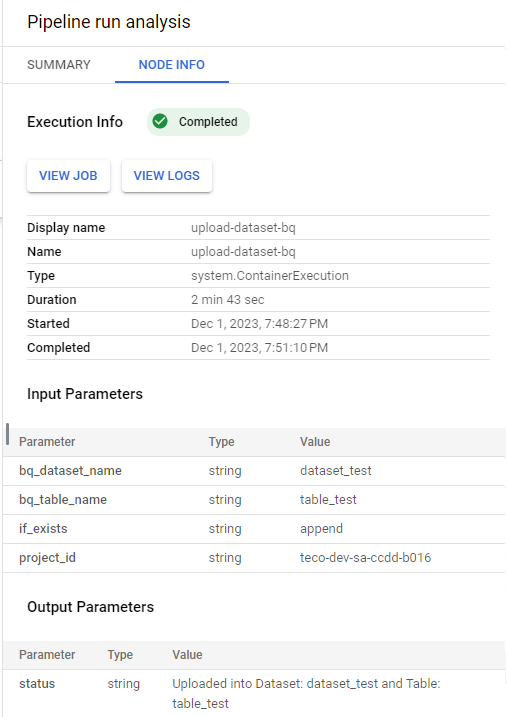

In [191]:
from IPython.display import Image
Image("img/upload.png")

## 5to Componente - Levanta los datos CSV

In [200]:
# en el decorador se setea los parametros para crear el contendor
@component(
    packages_to_install=["google-cloud-bigquery==3.10.0", "pandas==1.5.2", "pyarrow==7.0.0","db_dtypes==1.1.1","scikit-learn==1.2.0","fastparquet==2023.1.0"],
    base_image="python:3.9",
)
def get_dataframe_from_gcs(
        bucket_name: str,
        file_path: str,
        project_id : str, 
        dataset: Output[Dataset],
):
    """
        Descarga un dataset desde google cloud storage y lo envia como output
        Inputs: 
        - bucket_name: string con el nombre del bucket
        - project_id: id del proyecto de gcp
        - dataset_format: formato en el que se guarda el archivo, recibe "csv" o "parquet"
        Outputs:
        -  dataset: el dataset almacenado para poder enviarlo a otro componente


    """
    from google.cloud import bigquery
    import pandas as pd
    import numpy as np
    from google.cloud import storage
    
    storage_client = storage.Client(project  = project_id)
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(file_path)
    blob.download_to_filename(dataset.path + "." +  "csv")
    

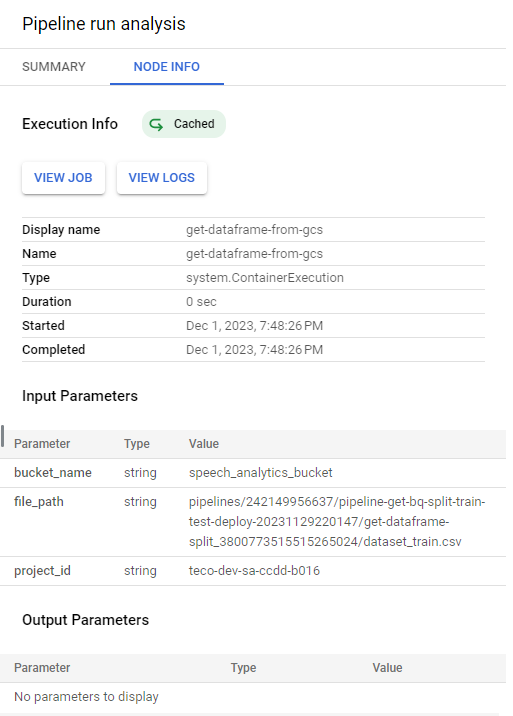

In [192]:
from IPython.display import Image
Image("img/get-gcs.png")

## 6to Componente - Levanta el modelo SKLEARN del Bucket

In [201]:
# en el decorador se setea los parametros para crear el contendor
@component(
    packages_to_install=["google-cloud", "pandas==1.5.2", "pyarrow","db_dtypes", "scikit-learn==1.2.0"],
    base_image="python:3.9",
)



def get_model_sklearn(
    model_conf_dict: dict,
    project_id: str, 
    model: Output[Model],
    get_features_name_file: bool = False,
    extension:str = ".pkl",
)-> NamedTuple("Outputs", [("features_names", list)]):
    """
        Descarga un direcotrio  desde el storage.
        Inputs:
        - model_config_dict: diccionario con los campos bucket_name ( nombre del bucket sin gs:// ) y source_blob_name ( path dentro del bucket hacia el modelo)
        - project_id: id del proyecto 
        - extension del archivo, default ".pkl"
        - get_features_name_file: Booleano, si es true ademas del modelo se obtiene un json desde el bucket, lo buscara en la mismo bucket y direccion del modelo por el nombre feature_names.json
    
        Outputs:
        - directory : Directorio 
    """
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split as tts
    import logging
    import pickle
    from google.cloud import storage
    import json
    
    feature_names_list=[]
    
    def download_blob(bucket_name, source_blob_name, destination_file_name, project_id):
        """Downloads a blob from the bucket."""
        # The ID of your GCS bucket
        # bucket_name = "your-bucket-name"

        # The ID of your GCS object
        # source_blob_name = "storage-object-name"

        # The path to which the file should be downloaded
        # destination_file_name = "local/path/to/file"

        storage_client = storage.Client(project  = project_id)

        bucket = storage_client.bucket(bucket_name)

        # Construct a client side representation of a blob.
        # Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
        # any content from Google Cloud Storage. As we don't need additional data,
        # using `Bucket.blob` is preferred here.
        logging.info(f"Bucando el modelo en: ")
        logging.info(f"{bucket_name}/{source_blob_name}{extension}")
        blob = bucket.blob(source_blob_name + extension)
        blob.download_to_filename(destination_file_name)

        logging.info(
            "Downloaded storage object {} from bucket {} to local file {}.".format(
                source_blob_name, bucket_name, destination_file_name
            )
        )


    download_blob(model_conf_dict.get("bucket_name"), model_conf_dict.get("source_blob_name"), model.path + extension, project_id )
    

    if get_features_name_file:
        # si get_features_name_file es true se descarga el json desde el bucket, se abre y se carga en la lista 
        logging.info("Obteniendo el nombre de las features en ")
        storage_client = storage.Client(project  = project_id)
        bucket = storage_client.bucket(model_conf_dict.get("bucket_name"))
        try:
            feature_name_json_blob = '/'.join(model_conf_dict.get("source_blob_name").split('/')[:-1]) + '/feature_names.json'
            blob = bucket.blob(feature_name_json_blob)
            blob.download_to_filename("feature_names.json")
            with open("feature_names.json", 'r') as json_file:
                feature_names_list = json.load(json_file)
        except Exception as e:
            logging.error(e)
            logging.error("Error al obtener el nombre de las features, revisar si en el bucket del modelo existe un archivo con el nombre feature_names.json")
        
        
    if len(feature_names_list) == 0:
        logging.warning("features_names se devuelve vacio ya que no se especifico el get_features_name_file")

    
    return (feature_names_list,)


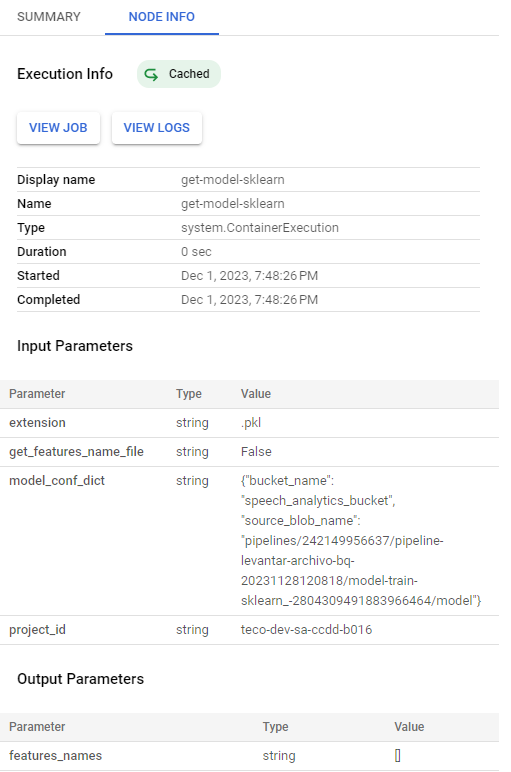

In [193]:
from IPython.display import Image
Image("img/model-get-sklearn.png")

# 7mo componente - Batch Prediction SKLearn

In [202]:

@component(
    packages_to_install=["google-cloud-aiplatform==1.26.1", "scikit-learn==1.2.0", "pandas==1.5.2", "kfp==1.8.22"],
    base_image="python:3.9",
)

def local_batch_prediction_sklearn(
    dataset: Input[Dataset],
    model: Input[Model],
    #predictions: Output[Dataset],
    predictors_variables: list,
    target_variable:list,

):
    """
        Componente para evaluar la performance de un sklearn recibiendo un parquet:
        Inputs:
        - dataset: Dataset en formato parquet dentro de un objeto de tipo Input[Dataset],
        recibido del componente anterior
        - model: modelo xgboost en formato pkl,
        - predictors_variables: lista con los nombres de las columnas que se utilizaran como predictoras
        - target_variable: lista con la/s variable/s objetivos
        - use_model_variables: indica si se utilizaran las variables alojadas en el modelo en lugar de las predictoras 
        Outputs
        - dataset_predicted: [ salida del componente] objeto dataset.
    """
    
    import logging
    import pandas as pd
    import pickle


    # Load dataset
    try:
        df = pd.read_csv(dataset.path + ".csv")
    except Exception as e:
        logging.error(f"Error loading dataset: {e}")
        raise

    # Load model
    try:
        #file_name = model.path + ".pkl"
        file_name = model.path + ".pkl"
        print(file_name)

        
        loaded_model = pickle.load(open(file_name, 'rb'))
        logging.info("Model loaded")
    except Exception as e:
        logging.error(f"Error loading model: {e}")
        raise

    # Perform prediction
    try:
        X = df[predictors_variables]
        predictions = loaded_model.predict(X)
        df = pd.DataFrame(predictions)
    except Exception as e:
        logging.error(f"Error during prediction: {e}")
        raise

    # Save results to Parquet
    #try:
    #    df.to_csv(predictions.path + "csv", index=False, encoding='utf-8-sig')
    #except Exception as e:
    #    logging.error(f"Error saving results to Parquet: {e}")
    #    raise
        
    

In [203]:
from datetime import datetime
timestamp =datetime.now().strftime("%Y%m%d%H%M%S")
display_name = 'pipeline-levantar-archivo-split-job{}'.format(timestamp)



project_id = 'teco-dev-sa-ccdd-b016'
bq_dataset_name_read='ccdd_yoizen_data'
bq_table_name_read='feat_ccdd_mabot_d'

In [204]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline. Use to determine the pipeline Context.
    name="pipeline-levantar-archivo-bq-get-model-bucket-inference-sklearn",
    
    
)
def armar_pipeline(
    query_string: str = """ 
    SELECT * FROM `project.dataset.table` WHERE partitionDate = '2023-11-01' limit 1000
    """, 
        
    project: str = project_id,
    region: str = REGION, 
    display_name: str = display_name,
    api_endpoint: str = REGION+"-aiplatform.googleapis.com",
    model_name: str = 'train_pipeline',
    model_version: str = "V1.0",
    serving_container_image_uri: str = "us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest",
    model_sklearn_conf_dict:  dict = {"source_blob_name": "pipelines/242149956637/pipeline-levantar-archivo-bq-20231128120818/model-train-sklearn_-2804309491883966464/model",
      "bucket_name": "speech_analytics_bucket"}
    ,
    model_pytorch_conf_dict:  dict = {"source_blob_name": "clasificacion_de_chats/best-checkpoint",
      "bucket_name": "speech_analytics_bucket"}
    ,    

    bucket_name: str = BUCKET_NAME,
    file_path: str = 'pipelines/242149956637/pipeline-get-bq-split-train-test-deploy-20231129220147/get-dataframe-split_3800773515515265024/dataset_train.csv',


    ):

    dataset_task_csv = get_dataframe_from_gcs(
        bucket_name =  BUCKET_NAME.split('/')[2], # 'speech_analytics_bucket'
        file_path = file_path,
        project_id= project_id,
        
#        ).set_retry(num_retries=10,  # Número de reintentos
#        backoff_duration='1800s',  # Duración del retroceso individual
#        backoff_max_duration='60000s'  # Duración máxima del retroceso, un poco mayor
    )        

    get_model_sklearn_task = get_model_sklearn(
        model_conf_dict = model_sklearn_conf_dict ,
        project_id= PROJECT_ID,
        )

    predict_model_task_sklearn_csv = local_batch_prediction_sklearn(
        dataset = dataset_task_csv.outputs["dataset"],
        model=get_model_sklearn_task.outputs["model"],
        predictors_variables = ['cant_recarga','cant_packs','revenue'],
        target_variable = ['segmento'],        
        
    )
            

        
    #print(PROJECT_ID)
    dataset_task_bq = get_dataframe_bq(
        query_string = query_string,
        project_id= project_id,
#        ).set_retry(num_retries=10,  # Número de reintentos
#        backoff_duration='1800s',  # Duración del retroceso individual
#        backoff_max_duration='60000s'  # Duración máxima del retroceso, un poco mayor
    )        

    get_clasificacion_de_chat_model_op = get_model_pytorch(
        model_conf_dict = model_pytorch_conf_dict,
        project_id= project_id,
        extension =".ckpt")

    pytorch_batch_prediction_op = local_batch_prediction_pytorch(
            data = dataset_task_bq.outputs["dataset"],
            model =  get_clasificacion_de_chat_model_op.outputs["model"],
            model_version = model_version,
        ).set_cpu_limit("8").set_memory_limit("5G").add_node_selector_constraint('accelerator', 'NVIDIA_TESLA_T4').set_gpu_limit("1")   
    
    upload_predictions_op = upload_dataset_bq(
        project_id = project_id,
        bq_dataset_name = 'dataset_test',
        bq_table_name = 'table_test',
        predictions = pytorch_batch_prediction_op.outputs["predictions_output"]
    )
            
        


In [ ]:
compiler.Compiler().compile(pipeline_func=armar_pipeline,
        package_path='template-levantar-archivo-bq.json')  

start_pipeline = pipeline_jobs.PipelineJob(
    display_name="pipeline-levantar-archivo-bq",
    template_path="template-levantar-archivo-bq.json",
    enable_caching=True,
    location=REGION,
)

start_pipeline.run()

Creating PipelineJob
PipelineJob created. Resource name: projects/242149956637/locations/us-central1/pipelineJobs/pipeline-levantar-archivo-bq-get-model-bucket-inference-sklearn-20231201230656
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/242149956637/locations/us-central1/pipelineJobs/pipeline-levantar-archivo-bq-get-model-bucket-inference-sklearn-20231201230656')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/pipeline-levantar-archivo-bq-get-model-bucket-inference-sklearn-20231201230656?project=242149956637
